## LDAをnumpyを使って一連の流れを理解
線形判別分析(Linear Discriminant Analusis)LDAの流れを追う。LDAは教師ありアルゴリズム(PCAは教師なし)なのでPCAより強力（の場合が多い）  
前提条件として  
・データが正規分布に従う  
・クラスの共分散行列が全く同じ  
・特徴量が統計的に互いに独立していること  
なので、使用するには制約が厳しい.満たしてなくても、うまくいくらしい  
1.d次元データセットを標準化(sklearnのStandardScaler)    
2.クラスごと平均ベクトルを計算  
3.クラス間変動行列S_B、クラス内変動行列S_Wを計算  
4.S_W*S_Bを固有値と固有ベクトルに分解(numpyのnp,linalg.eig)    
5.最も大きいk個の固有値に対応するk個の固有ベクトルを選択（この流れは可視化のために便宜上k=2にしている）  
6.上位k個の固有ベクトルから射影行列Wを作成(numpyのnp.hstackで固有ベクトルを連結)  
7.射影行列Wを使ってd次元データセットを変換して,新しいk次元の特徴量を手に入れる  

## 1.d次元データセットを標準化(sklearnのStandardScaler)    


In [3]:
import pandas as pd
import numpy as np

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']
df_wine.head()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X=df_wine.iloc[:,1:]
y=df_wine.iloc[:,0]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
sc=StandardScaler()
X_train_std=sc.fit_transform(X_train)
X_test_std=sc.transform(X_test)

## 2.クラスごと平均ベクトルを計算

In [4]:
np.set_printoptions(precision=4)
mean_vecs=[]
for label in range(1,len(np.unique(y))+1):
    # axis=0とすることで各列の特徴量の平均値を取ることができる.なので返り値は特徴量数の長さの配列
    mean_vecs.append(np.mean(X_train_std[y_train==label],axis=0))
    print('MV %s: %s\n' %(label,mean_vecs[label-1]))

MV 1: [ 0.9198 -0.3075  0.3117 -0.7707  0.3571  0.9424  1.0813 -0.6109  0.5657
  0.1902  0.5024  0.8202  1.1967]

MV 2: [-0.8942 -0.418  -0.4675  0.2214 -0.2926 -0.0748  0.0313 -0.0577  0.1011
 -0.891   0.4644  0.292  -0.7087]

MV 3: [ 1.8548e-01  8.7684e-01  2.7821e-01  5.3578e-01  5.6683e-04 -9.1185e-01
 -1.1995e+00  7.3007e-01 -7.3855e-01  9.6293e-01 -1.1464e+00 -1.2612e+00
 -3.5417e-01]



## 3.クラス間変動行列S_B、クラス内変動行列S_Wを計算  

In [5]:
# クラス内変動行列S_Wを求める
d=X_train.shape[1]
S_W=np.zeros((d,d))
for label,mv in zip(range(1,len(np.unique(y_train)+1)),mean_vecs):
    class_scatter=np.zeros((d,d))
    for row in X_train_std[y_train==label]:
        # 変動行列を計算
        row,mv=row.reshape(d,1),mv.reshape(d,1)
        class_scatter+=(row-mv).dot((row-mv).T)
    S_W+=class_scatter

### このままLDAすると、クラスの分布がうまく行かないので正規化する

In [6]:
print('class label distribution: %s' % np.bincount(y_train)[1:])

class label distribution: [45 55 42]


In [8]:
#正規化した変動行列を求める。すなわち、共分散行列を求めることと同じ
d = X_train.shape[1]
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0],
                                                     S_W.shape[1]))

# クラス内変動行列を求める
mean_overall = np.mean(X_train_std, axis=0)
d =X_train.shape[1]
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Scaled within-class scatter matrix: 13x13
Between-class scatter matrix: 13x13


## 4.S_W*S_Bを固有値と固有ベクトルに分解(numpyのnp,linalg.eig)    
## 5.最も大きいk個の固有値に対応するk個の固有ベクトルを選択（この流れは可視化のために便宜上k=2にしている） 

In [9]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

#固有値と固有ベクトルのペアを作成
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

#固有値が大きい順番に並び替え 
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

544.9409138254811
187.26591131223122
4.853374971125164e-14
4.1281391006153586e-14
4.1281391006153586e-14
3.303972443675131e-14
3.303972443675131e-14
2.1762941134571637e-14
1.2907382852490287e-14
1.2907382852490287e-14
3.9813989247888525e-15
2.940593750158527e-15
0.0


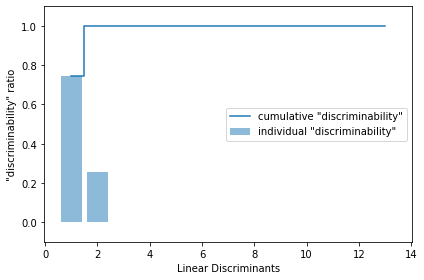

In [11]:
# 固有値の実数部の総和を求める
tot = sum(eigen_vals.real)
# 分散説明率と累積和を求める
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## 6.上位k個の固有ベクトルから射影行列Wを作成(numpyのnp.hstackで固有ベクトルを連結) 

In [12]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
w

array([[-0.0816, -0.3969],
       [ 0.066 , -0.2356],
       [-0.03  , -0.3811],
       [ 0.1629,  0.3243],
       [ 0.0047, -0.0071],
       [ 0.2207,  0.0776],
       [-0.7881,  0.0992],
       [-0.0901,  0.0393],
       [ 0.0651,  0.206 ],
       [ 0.2012, -0.3168],
       [-0.0551,  0.2306],
       [-0.3749,  0.0273],
       [-0.3085, -0.5678]])

## 7.射影行列Wを使ってd次元データセットを変換して,新しいk次元の特徴量を手に入れる  

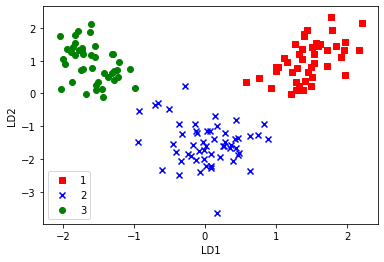

In [13]:
X_train_lda=X_train_std.dot(w)
colors=['r','b','g']
markers=['s','x','o']

for l,c,m in zip(np.unique(y_train),colors,markers):
    plt.scatter(X_train_lda[y_train==l,0]*-1,X_train_lda[y_train==l,1]*-1,c=c,marker=m,label=l)
    
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower left')

plt.show()